Install the latest PyPi distribution of snnTorch:

In [149]:
!pip install snntorch

## 1. Setting up the MNIST Dataset

### 1.1. Import packages and setup environment

In [150]:
import snntorch as snn
import torch

In [5]:
# Training Parameters
batch_size=128
data_path='/tmp/data/mnist'
num_classes = 10  # MNIST has 10 output classes

# Torch Variables
dtype = torch.float

### 1.2 Download Dataset

In [148]:
from torchvision import datasets, transforms

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28,28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)

Until we actually start training a network, we won't need large datasets.
`snntorch.utils` contains a few useful functions for modifying datasets. Apply `data_subset` to reduce the dataset by the factor defined in `subset`. *E.g., for `subset=10`, a training set of 60,000 will be reduced to 6,000.*


In [7]:
from snntorch import utils

subset = 10
mnist_train = utils.data_subset(mnist_train, subset)
print(f"The size of mnist_train is {len(mnist_train)}")

The size of mnist_train is 6000


### 1.3 Create DataLoaders
The Dataset objects created above load data into memory, and the DataLoader will serve it up in batches. DataLoaders in PyTorch are a handy interface for passing data into a network. They return an iterator divided up into mini-batches of size ``batch_size``.

In [8]:
from torch.utils.data import DataLoader

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

### 2.1 Rate coding of MNIST

One example of converting input data into a rate code is as follows.
Each normalised input feature $X_{ij}$ is used as the probability an event (spike) occurs at any given time step, returning a rate-coded value $R_{ij}$. This can be treated as a Bernoulli trial: $R_{ij}\sim B(n,p)$, where the number of trials is $n=1$, and the probability of success (spiking) is $p=X_{ij}$. Explicitly, the probability a spike occurs is:

$${\rm P}(R_{ij}=1) = X_{ij} = 1 - {\rm P}(R_{ij} = 0)$$

Create a vector filled with the value '0.5' and encode it using the above technique:

In [9]:
# Temporal Dynamics
num_steps = 10

# create vector filled with 0.5
raw_vector = torch.ones(num_steps)*0.5

# pass each sample through a Bernoulli trial
rate_coded_vector = torch.bernoulli(raw_vector)
print(f"Converted vector: {rate_coded_vector}")

print(f"The output is spiking {rate_coded_vector.sum()*100/len(rate_coded_vector):.2f}% of the time.")

Converted vector: tensor([0., 0., 0., 1., 1., 1., 1., 0., 1., 0.])
The output is spiking 50.00% of the time.


Now try again, but increasing the length of `raw_vector`:

In [10]:
num_steps = 100

# create vector filled with 0.5
raw_vector = torch.ones(num_steps)*0.5

# pass each sample through a Bernoulli trial
rate_coded_vector = torch.bernoulli(raw_vector)
print(f"The output is spiking {rate_coded_vector.sum()*100/len(rate_coded_vector):.2f}% of the time.")

The output is spiking 49.00% of the time.


As `num_steps`$\rightarrow\infty$, the proportion of spikes approaches the original raw value.

In [11]:
from snntorch import spikegen

# Iterate through minibatches
data = iter(train_loader)
data_it, targets_it = next(data)

# Spiking Data
spike_data = spikegen.rate(data_it, num_steps=num_steps)

If the input falls outside of $[0,1]$, this no longer represents a probability. Such cases are automatically clipped to ensure the feature represents a probability.

The structure of the input data is ``[num_steps x batch_size x input dimensions]``:

In [11]:
print(spike_data.size())

torch.Size([100, 128, 1, 28, 28])


In [ ]:
def rmse(s1,s2):
  squared_err = (s1-s2) **2
  mean_squared_err = torch.mean(squared_err)
  root_mse = torch.sqrt(mean_squared_err)
  return root_mse

In [ ]:
def afr(spike_train, num_steps):
  num_spk = torch.sum(spike_train).item() # Extract the numerical value of the single tensor with .item()
  Avg_firing_rate = num_spk / num_steps
  return Avg_firing_rate

### 2.2 Visualization

#### 2.2.1 Animation
snnTorch contains a module [`snntorch.spikeplot`](https://snntorch.readthedocs.io/en/latest/snntorch.spikeplot.html) that simplifies the process of visualizing, plotting, and animating spiking neurons.


In [12]:
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

To plot one sample of data, index into a single sample from the batch (B) dimension of `spike_data`, ``[T x B x 1 x 28 x 28]``:

In [87]:

spike_data_sample = spike_data[:, 16, 0]

spike_data_sample4 = spike_data[:, 0, 0]

spike_data_sample5 = spike_data[:, 11, 0]

spike_data_sample7 = spike_data[:, 6, 0]

spike_data_sample9 = spike_data[:, 22, 0]

spike_data_sample11 = spike_data[:, 14, 0]

spike_data_sample13 = spike_data[:, 19, 0]

spike_data_sample15 = spike_data[:, 12, 0]

spike_data_sample17 = spike_data[:, 7, 0]

spike_data_sample19 = spike_data[:, 8, 0]



print(spike_data_sample.size())

torch.Size([260, 28, 28])


In [145]:
dict = {}

for i in range(100):
  if targets_it[i].item() not in dict:
    dict[targets_it[i].item()] = i
  if len(dict) == 10:
    break
print(dict)

print(f"The corresponding target is: {targets_it[2]}")

{4: 0, 5: 1, 7: 2, 3: 4, 9: 6, 2: 10, 8: 15, 0: 16, 6: 18, 1: 20}
The corresponding target is: 7


The associated target label can be indexed as follows:

MNIST features a greyscale image, and the white text guarantees a 100% of spiking at every time step. So let's do that again but reduce the spiking frequency. This can be achieved by setting the argument `gain`. Here, we will reduce spiking frequency to 25%.

16
20
10
4
0
1
18
2
15
6


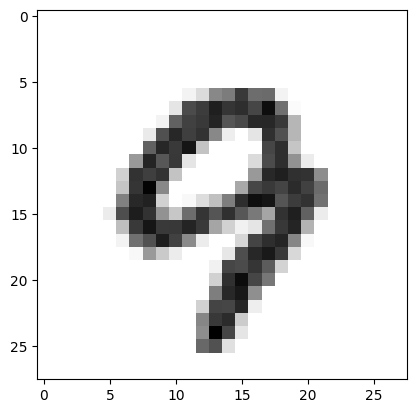

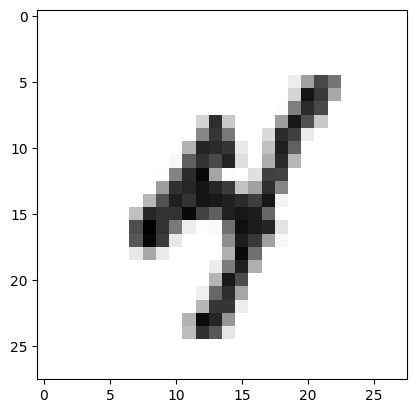

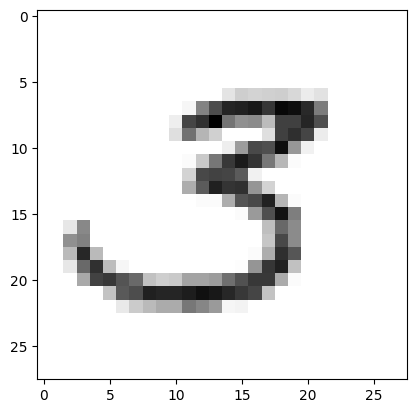

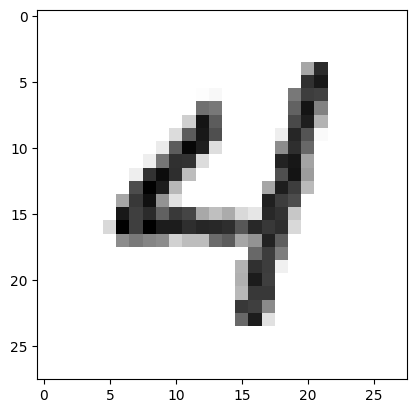

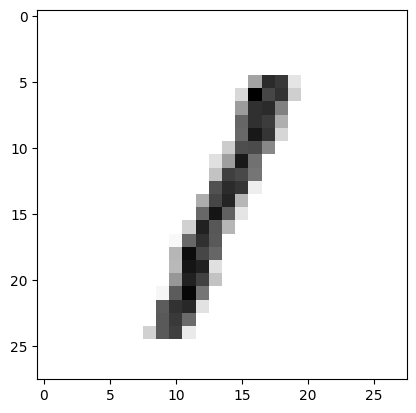

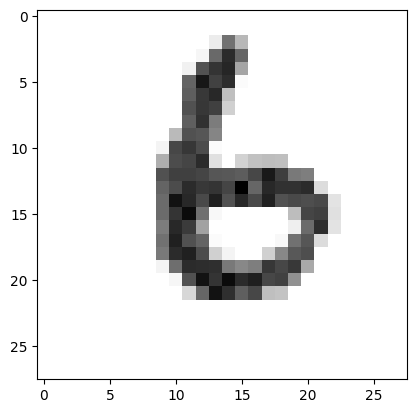

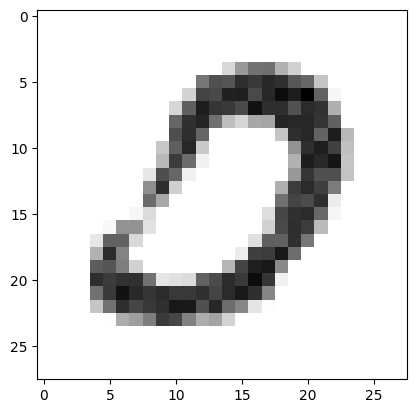

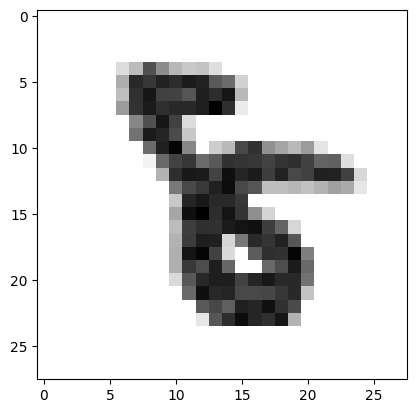

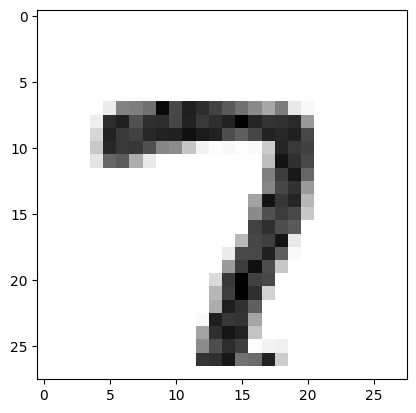

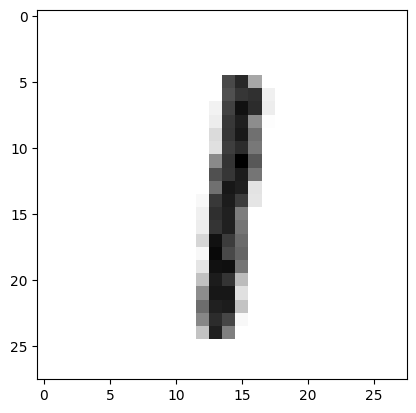

<Figure size 640x480 with 0 Axes>

In [147]:
spike_data = spikegen.rate(data_it, num_steps=num_steps, gain=0.33)


for i in range(10):
  spike_data_sample = spike_data[:, dict[i], 0]
  print(dict[i])
  plt.imshow(spike_data_sample.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
  plt.figure(facecolor="w")
  plt



Now average the spikes out over time and reconstruct the input images.

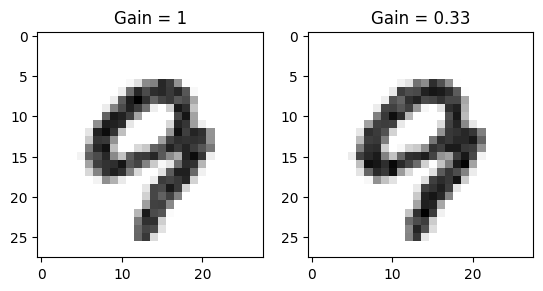

In [133]:
plt.figure(facecolor="w")
plt.subplot(1,2,1)
plt.imshow(spike_data_sample.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('on')
plt.title('Gain = 1')

plt.subplot(1,2,2)
plt.imshow(spike_data_sample2.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('on')
plt.title('Gain = 0.33')

plt.show()

## Part 2 LIF Neuron

In [ ]:
# LIF w/Reset mechanism
def leaky_integrate_and_fire(mem, cur=0, threshold=1, time_step=1e-3, R=5.1, C=5e-3):
  tau_mem = R*C
  spk = (mem > threshold)
  mem = mem + (time_step/tau_mem)*(-mem + cur*R) - spk*threshold  # every time spk=1, subtract the threhsold
  return mem, spk